In [5]:
!pip install calflops
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import os
import re
import numpy as np

from calflops import calculate_flops_hf
from decimal import Decimal

batch_size, max_seq_length = 1, 1
opt_names = ["facebook/opt-125m",
             "facebook/opt-350m", 
             "facebook/opt-1.3b", 
             "facebook/opt-2.7b", 
             "facebook/opt-6.7b",
             "facebook/opt-13b",
             "facebook/opt-30b",
             "facebook/opt-66b",
            ]
pythia_names = ["EleutherAI/pythia-160m-v0", 
              "EleutherAI/pythia-1b", 
              "EleutherAI/pythia-410m-v0",
             "EleutherAI/pythia-12b-v0",
              "EleutherAI/pythia-6.9b-v0",
              "EleutherAI/pythia-2.8b-v0"
             ]
bloom_names = ["bigscience/bloom-560m",
             "bigscience/bloom-7b1",
              "bigscience/bloom-1b7",
               "bigscience/bloom-1b1",
             "bigscience/bloom-3b",
             ]
# "facebook/opt-1.3b"

def get_all_flops_from_hf(compute_bp_factor):
    dd=dict()
    for model_name in opt_names+pythia_names+bloom_names:
        try:
            fwd_flops, macs, params = calculate_flops_hf(model_name=model_name,
                                                     compute_bp_factor=compute_bp_factor, 
                                                     input_shape=(1,1))
        except:
            import traceback
            print(traceback.format_exc())
        else:
            fwd_flops = fwd_flops.replace("FLOPS","")\
            .replace("K","* 1e3")\
            .replace("M", " * 1e6 ")\
            .replace("G", "* 1e9")\
            .replace("T","* 1e12")\
            .replace("P", "* 1e15")
            # print(flops.replace("K","* 1e3").replace("M", " * 1e6 ").replace("G", "* 1e9"))
            flops= eval(fwd_flops)*(1.0+compute_bp_factor)
            print(f"#### {model_name}:",f"{flops:e}")
            dd[model_name] = flops
            print(model_name)

    return dd
    
#import json
#json.dumps({k:v*name2num_trainedtokens(k) for k,v in dd.items()})
# print("%s FLOPs:%s  MACs:%s  Params:%s \n" %(model_name, flops, macs, params))

def preprocess_rwkv4():
    df = pd.read_csv("./RWKV.csv", index_col=0)
    df = df.reset_index()
    print(df.columns)
    df = df.groupby("index")
    rwkv = df.get_group('RWKV-4')
    pythia = df.get_group('Pythia')

    for col in rwkv.columns[2:]:
        rwkv.loc[:, col] = rwkv[col].apply(lambda x: float(x[:-1]))
        pythia.loc[:, col] = pythia[col].apply(lambda x: float(x[:-1]))

    rwkv.columns = map(str.lower, rwkv.columns)
    pythia.columns = map(str.lower, pythia.columns)
    
    return rwkv, pythia

def preprocess_rwkv5():
    df = pd.read_csv("./RWKV_5_and_6.100.csv", index_col=0)
    df = df.reset_index()
    print(df.columns)
    df = df.groupby("model")
    rwkv = df.get_group('RWKV-5')
    # pythia = df.get_group('Pythia')

    #for col in rwkv.columns[3:]:
    #    print(rwkv[col])
    #    rwkv.loc[:, col] = rwkv[col].apply(lambda x: float(x[:-1]))
        # pythia.loc[:, col] = pythia[col].apply(lambda x: float(x[:-1]))

    rwkv.columns = map(str.lower, rwkv.columns)
    # pythia.columns = map(str.lower, pythia.columns)
    # rwkv.
    return rwkv[["lambada.1",    "piqa",  "winogrande",   "sciq",  "arc_easy", "arc_challenge"]].rename({"lambada.1":"lambada"}, axis='columns')
    # , pythia


def get_data(model, tasks):
    dir = f"pythia/evals/{model}"
    files = os.listdir(dir)
    accs = {task: [] for task in tasks}
    params = []
    for file in files:
        if file.endswith("json"):
            if model == "bloom":
                s1 = r"(\d+)b(\d*)"
            else:
                s1 = r"(\d+\.?\d+)b"
            s2 = r"(\d+)m"
            print(file)
            param1 = re.search(s1, str(file), re.M|re.I)
            param2 = re.search(s2, str(file), re.M | re.I)
            if param1 and param1.group(1):
                if model == "bloom":
                    params.append(float(f"{param1.group(1)}.{param1.group(2)}"))
                else:
                    params.append(float(param1.group(1).strip('b')))
            else:
                print(param2)
                params.append(float(param2.group(0).strip('m'))/1000.0)
            # params.append(param)
            f = open(os.path.join(dir, file), "r")
            obj = json.load(f)
            keys = obj['results'].keys()
            for task in tasks:
                r = re.compile(f".*{task}.*")
                key = list(filter(r.match, keys))[0]
                accs[task].append(float(obj['results'][key]['acc'])*100.0)
    
    params = sorted(params)
    for task in tasks:
        accs[task] = np.array([x for _, x in sorted(zip(params, accs[task]))])
        
    
    
    return accs, params


def _plot(rwkv, rwkv5, pythia, opt_params, opt_acc, bloom_params, bloom_acc, tasks):
    
    for task in tasks:
        print("5:",task,"\n",rwkv5["flops"],rwkv5[task])
        print("4:",task,"\n",rwkv["flops"],rwkv[task])
        fig = plt.figure()

        plt.plot(rwkv5['flops'], rwkv5[task] * 1, "o-", markersize=4, color='red')
        if task == "lambada":
            plt.plot(rwkv['flops'], rwkv['lambada.1'] * 1, "o-", markersize=4, color='orange')
            plt.plot(pythia['flops'], pythia['lambada.1'] * 1, "s-", markersize=4, color='blue')
        else:
            # plt.plot(rwkv5['flops'], rwkv5[task] * 1, "o-", markersize=4, color='red')
            plt.plot(rwkv['flops'], rwkv[task] * 1, "o-", markersize=4, color='orange')
            plt.plot(pythia['flops'], pythia[task] * 1, "s-", markersize=4, color='blue')
        
        
        plt.plot(opt_params, opt_acc[task] * 1, "^-", markersize=4, color='green')
        plt.plot(bloom_params, bloom_acc[task] * 1, "v-", markersize=4, color='brown')

        plt.legend(['RWKV-5','RWKV-4', 'Pythia', 'OPT', 'BLOOM'], loc='lower right',fontsize=15)
        X_label = 'Flops'
        Y_label = 'Accuracy'
        plt.xlabel(f"{X_label}",fontsize=22)
        plt.ylabel(f"{Y_label}",fontsize=22)

        
        if task == "lambada":
            y_low = np.floor(np.min([*opt_acc[task], *bloom_acc[task], *rwkv["lambada.1"], *rwkv[task],  *pythia["lambada.1"]]) / 1)
            y_high = np.ceil(np.max([*opt_acc[task], *bloom_acc[task], *rwkv["lambada.1"], *rwkv[task],  *pythia["lambada.1"]]) / 1)
        else:
            y_low = np.floor(np.min([*opt_acc[task], *bloom_acc[task], *rwkv[task],  *pythia[task]]) / 1)
            y_high = np.ceil(np.max([*opt_acc[task], *bloom_acc[task], *rwkv[task],  *pythia[task]]) / 1)

        
        # print(np.arange(y_low - 5, y_high + 5, 1))

        plt.xscale('log')
        # plt.yscale('log')
        plt.grid(axis='y', which='both')
        # plt.grid(visible=True, which='both')

        yfmt = ticker.FormatStrFormatter('%.1f')

        ax = fig.get_axes()[0]

        # ax.yaxis.set_minor_formatter(yfmt)
        # ax.yaxis.set_minor_formatter(yfmt)
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
        ax.xaxis.set_tick_params(labelsize=17)
        ax.yaxis.set_tick_params(labelsize=17)
        


        scale = 1
        for i in range(4):
            ydata = ax.lines[i].get_ydata()
            ydata = scale * ydata
            ax.lines[i].set_ydata(ydata)
        # plt.tight_layout()
        
        plt.ylim([scale*(y_low - 10), scale*(y_high + 10)])
        ticks = np.arange(y_low - 10, y_high + 10, 5)
        plt.yticks(ticks=scale*ticks, labels=ticks)
        
        
        plt.title(f"{task}", fontsize=25)
        plt.savefig(f"acc_{task}.png")

        plt.show()
        
def plot(rwkv, rwkv5, pythia, opt_params, opt_acc, bloom_params, bloom_acc, tasks):
    
    for task in tasks:
        print("5:",task,"\n",rwkv5["flops"],rwkv5[task])
        print("4:",task,"\n",rwkv["flops"],rwkv[task])
        fig = plt.figure()

        plt.plot(rwkv5['flops'], rwkv5[task] * 1, "o-", markersize=4, color='red', linestyle='--')
        print(task)
        if task == "lambada":
            plt.plot(rwkv['flops'], rwkv['lambada.1'] * 1, "o-", markersize=4, color='orange', linestyle='--')
            plt.plot(pythia['flops'], pythia['lambada.1'] * 1, "s-", markersize=4, color='blue', linestyle='--')
        else:
            plt.plot(rwkv['flops'], rwkv[task] * 1, "o-", markersize=4, color='orange', linestyle='--')
            plt.plot(pythia['flops'], pythia[task] * 1, "s-", markersize=4, color='blue', linestyle='--')
        
        
        plt.plot(opt_params, opt_acc[task] * 1, "^-", markersize=4, color='green', linestyle='--')
        plt.plot(bloom_params, bloom_acc[task] * 1, "v-", markersize=4, color='brown', linestyle='--')

        plt.legend(['RWKV-5','RWKV-4', 'Pythia', 'OPT', 'BLOOM'], loc='lower right',fontsize=15)
        X_label = 'Flops'
        Y_label = 'Accuracy'
        plt.xlabel(f"{X_label}",fontsize=22)
        plt.ylabel(f"{Y_label}",fontsize=22)
        
        # assert False, rwkv5[task]
        
        if task == "lambada":
            y_low = np.floor(np.min([*opt_acc[task], *bloom_acc[task],  *rwkv5[task],  *pythia["lambada.1"]]) / 1)
            y_high = np.ceil(np.max([*opt_acc[task], *bloom_acc[task],  *rwkv5[task],  *pythia["lambada.1"]]) / 1)
        else:
            y_low = np.floor(np.min([*opt_acc[task], *bloom_acc[task], *rwkv[task], *rwkv5[task],  *pythia[task]]) / 1)
            y_high = np.ceil(np.max([*opt_acc[task], *bloom_acc[task], *rwkv[task], *rwkv5[task],  *pythia[task]]) / 1)

        
        # print(np.arange(y_low - 5, y_high + 5, 1))

        plt.xscale('log')
        # plt.yscale('log')
        plt.grid(axis='y', which='both')
        # plt.grid(visible=True, which='both')

        yfmt = ticker.FormatStrFormatter('%.1f')

        ax = fig.get_axes()[0]

        # ax.yaxis.set_minor_formatter(yfmt)
        # ax.yaxis.set_minor_formatter(yfmt)
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
        ax.xaxis.set_tick_params(labelsize=17)
        ax.yaxis.set_tick_params(labelsize=17)
        
        # for i in range(5):
        #      ydata = ax.lines[i].get_ydata()
        #     print(ydata)
        # assert False


        scale = 1
        for i in range(4):
            ydata = ax.lines[i].get_ydata()
            ydata = scale * ydata
            ax.lines[i].set_ydata(ydata)
        # plt.tight_layout()
        
        plt.ylim([scale*(y_low - 10), scale*(y_high + 10)])
        ticks = np.arange(y_low - 10, y_high + 10, 5)
        plt.yticks(ticks=scale*ticks, labels=ticks)
        
        
        plt.title(f"{task}", fontsize=25)
        plt.savefig(f"acc_{task}.png", bbox_inches='tight')

        plt.show()





huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [6]:
%matplotlib inline

In [7]:

def get_flops_data(model, tasks, model2flops_dict):
    dir = f"pythia/evals/{model}"
    files = os.listdir(dir)
    accs = {task: [] for task in tasks}
    flops = []
    for file in files:
        if file.endswith("json"):
            if model == "bloom":
                s1 = r"(\d+)b(\d*)"
            else:
                s1 = r"(\d+\.?\d+)b"
            s2 = r"(\d+)m"
            print(file)
            f = open(os.path.join(dir, file), "r")
            obj = json.load(f)
            keys = obj['results'].keys()
            for task in tasks:
                r = re.compile(f".*{task}.*")
                key = list(filter(r.match, keys))[0]
                accs[task].append(float(obj['results'][key]['acc'])*100.0)
            
            flops.append(model2flops_dict[file.rstrip(".json")])

    print(flops)
    for task in tasks:
        accs[task] = np.array([x for _, x in sorted(list(zip(flops, accs[task])), key=lambda x:x[0])])
        print("get_flops_data:",task, accs[task])

    return accs, sorted(flops)

def name2num_trainedtokens(name):
    # Billion = 1e9, Trillion = 1e12
    # * OPT : 180B : https://arxiv.org/pdf/2205.01068.pdf
    # * Pythia : 300B tokens : https://arxiv.org/pdf/2304.01373.pdf
    # * BLOOM : 341+25=366B : https://arxiv.org/pdf/2211.05100.pdf

    if name.startswith("facebook/opt"):
        # 180 B tokens
        return 180 * 1e9
    elif name.startswith("EleutherAI/pythia"):
        # 300 B tokens
        return 300 * 1e9
    elif name.startswith("bigscience/bloom"):
        # 366 B tokens
        return 366 * 1e9
    elif "rwkv5" in name or "rwkv6" in name:
        # 1.12 T tokens
        return 1.12 * 1e12
    else:
        raise Exception("")

def get_flops_rwkv4(compute_bp_factor):
    names = '169M 430M 1.5B 3B 7B'.split()
    N = len(names)
    L = [12,24,24,32,32,40]
    D = [768,1024,2048,2560,4096,5120]
    V = 50277
    params = [2*V*D[i] + 13*(D[i]**2)*L[i] + (11*L[i]+4)*D[i] for i in range(N)]
    # flops = [p*(1+compute_bp_factor) for p in params]
    flops = [(1+compute_bp_factor)*2*(V*D[i] + 13*(D[i]**2)*L[i]) for i in range(N)]
    
    return flops


In [8]:

dd = get_all_flops_from_hf(2.0)

Loading pretrained config for `facebook/opt-125m` from `transformers`...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  125.24 M
fwd MACs:                                                               84.93 MMACs
fwd FLOPs:                                                              170 MFLOPS
fwd+bwd MACs:                                                           254.8 MMACs
fwd+bwd FLOPs:                                                          510.01 MFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacu

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  331.2 M 
fwd MACs:                                                               303.04 MMACs
fwd FLOPs:                                                              606.42 MFLOPS
fwd+bwd MACs:                                                           909.12 MMACs
fwd+bwd FLOPs:                                                          1.82 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module c

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  1.32 B  
fwd MACs:                                                               1.21 GMACs
fwd FLOPs:                                                              2.42 GFLOPS
fwd+bwd MACs:                                                           3.62 GMACs
fwd+bwd FLOPs:                                                          7.25 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module caculat

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  2.65 B  
fwd MACs:                                                               2.52 GMACs
fwd FLOPs:                                                              5.03 GFLOPS
fwd+bwd MACs:                                                           7.55 GMACs
fwd+bwd FLOPs:                                                          15.1 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module caculat

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  6.66 B  
fwd MACs:                                                               6.44 GMACs
fwd FLOPs:                                                              12.89 GFLOPS
fwd+bwd MACs:                                                           19.33 GMACs
fwd+bwd FLOPs:                                                          38.66 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacu

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  12.85 B 
fwd MACs:                                                               12.58 GMACs
fwd FLOPs:                                                              25.17 GFLOPS
fwd+bwd MACs:                                                           37.75 GMACs
fwd+bwd FLOPs:                                                          75.51 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cac

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  29.97 B 
fwd MACs:                                                               29.6 GMACs
fwd FLOPs:                                                              59.19 GFLOPS
fwd+bwd MACs:                                                           88.79 GMACs
fwd+bwd FLOPs:                                                          177.58 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cac

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  65.72 B 
fwd MACs:                                                               65.23 GMACs
fwd FLOPs:                                                              130.47 GFLOPS
fwd+bwd MACs:                                                           195.69 GMACs
fwd+bwd FLOPs:                                                          391.4 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module c

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  123.69 M
fwd MACs:                                                               84.95 MMACs
fwd FLOPs:                                                              170 MFLOPS
fwd+bwd MACs:                                                           254.86 MMACs
fwd+bwd FLOPs:                                                          510.01 MFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cac

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  908.76 M
fwd MACs:                                                               805.37 MMACs
fwd FLOPs:                                                              1.61 GFLOPS
fwd+bwd MACs:                                                           2.42 GMACs
fwd+bwd FLOPs:                                                          4.83 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacul

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  353.82 M
fwd MACs:                                                               302.04 MMACs
fwd FLOPs:                                                              604.33 MFLOPS
fwd+bwd MACs:                                                           906.12 MMACs
fwd+bwd FLOPs:                                                          1.81 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module c

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  11.59 B 
fwd MACs:                                                               11.32 GMACs
fwd FLOPs:                                                              22.65 GFLOPS
fwd+bwd MACs:                                                           33.97 GMACs
fwd+bwd FLOPs:                                                          67.96 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cac

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  6.65 B  
fwd MACs:                                                               6.44 GMACs
fwd FLOPs:                                                              12.89 GFLOPS
fwd+bwd MACs:                                                           19.33 GMACs
fwd+bwd FLOPs:                                                          38.66 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacu

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  2.65 B  
fwd MACs:                                                               2.52 GMACs
fwd FLOPs:                                                              5.03 GFLOPS
fwd+bwd MACs:                                                           7.55 GMACs
fwd+bwd FLOPs:                                                          15.1 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module caculat

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  559.21 M
fwd MACs:                                                               301.99 MMACs
fwd FLOPs:                                                              604.24 MFLOPS
fwd+bwd MACs:                                                           905.97 MMACs
fwd+bwd FLOPs:                                                          1.81 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module c

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  7.07 B  
fwd MACs:                                                               6.04 GMACs
fwd FLOPs:                                                              12.08 GFLOPS
fwd+bwd MACs:                                                           18.12 GMACs
fwd+bwd FLOPs:                                                          36.24 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacu

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  1.72 B  
fwd MACs:                                                               1.21 GMACs
fwd FLOPs:                                                              2.42 GFLOPS
fwd+bwd MACs:                                                           3.62 GMACs
fwd+bwd FLOPs:                                                          7.25 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module caculat

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  1.07 B  
fwd MACs:                                                               679.48 MMACs
fwd FLOPs:                                                              1.36 GFLOPS
fwd+bwd MACs:                                                           2.04 GMACs
fwd+bwd FLOPs:                                                          4.08 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacul

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  3 B     
fwd MACs:                                                               2.36 GMACs
fwd FLOPs:                                                              4.72 GFLOPS
fwd+bwd MACs:                                                           7.08 GMACs
fwd+bwd FLOPs:                                                          14.16 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacula

/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:224: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv5['flops'], rwkv5[task] * 1, "o-", markersize=4, color='red', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:227: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv['flops'], rwkv['lambada.1'] * 1, "o-", markersize=4, color='orange', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:228: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pythia['flops'], pythia['lambada.1']

{'facebook/opt-125m': 510000000.0, 'facebook/opt-350m': 1819260000.0, 'facebook/opt-1.3b': 7260000000.0, 'facebook/opt-2.7b': 15090000000.0, 'facebook/opt-6.7b': 38670000000.0, 'facebook/opt-13b': 75510000000.0, 'facebook/opt-30b': 177570000000.0, 'facebook/opt-66b': 391410000000.0, 'EleutherAI/pythia-160m-v0': 510000000.0, 'EleutherAI/pythia-1b': 4830000000.0, 'EleutherAI/pythia-410m-v0': 1812990000.0, 'EleutherAI/pythia-12b-v0': 67950000000.0, 'EleutherAI/pythia-6.9b-v0': 38670000000.0, 'EleutherAI/pythia-2.8b-v0': 15090000000.0, 'bigscience/bloom-560m': 1812720000.0, 'bigscience/bloom-7b1': 36240000000.0, 'bigscience/bloom-1b7': 7260000000.0, 'bigscience/bloom-1b1': 4080000000.0, 'bigscience/bloom-3b': 14160000000.0, 'rwkv5-0.46b': 2865586176.0, 'rwkv5-1.68b': 9657040896.0, 'rwkv5-3b': 18695516160.0, 'rwkv5-7.52b': 45300000000.0}
opt-6.7b.json
opt-125m.json
opt-66b.json
opt-13b.json
opt-1.3b.json
opt-30b.json
opt-350m.json
opt-2.7b.json
[6.9606e+21, 9.18e+19, 7.04538e+22, 1.35918e+2

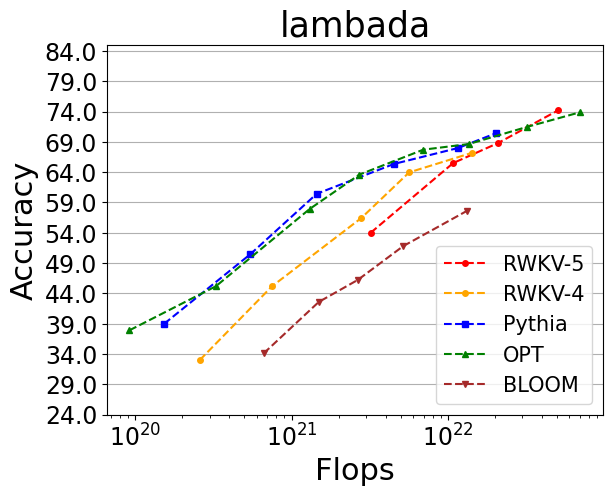

5: piqa 
 0    3.209457e+21
1    1.081589e+22
2    2.093898e+22
3    5.073600e+22
Name: flops, dtype: float64 0    66.5
1    71.2
2    74.2
3    77.3
Name: piqa, dtype: float64
4: piqa 
 1       258638054400000000000
5       749705932800000000000
9      2794948485120000000000
13     5652913305600000000000
17    14226807767040000000000
Name: flops, dtype: object 1     65.07
5     67.52
9     72.36
13    74.16
17    76.06
Name: piqa, dtype: object
piqa


/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:224: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv5['flops'], rwkv5[task] * 1, "o-", markersize=4, color='red', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:230: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv['flops'], rwkv[task] * 1, "o-", markersize=4, color='orange', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:231: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pythia['flops'], pythia[task] * 1, "s-", ma

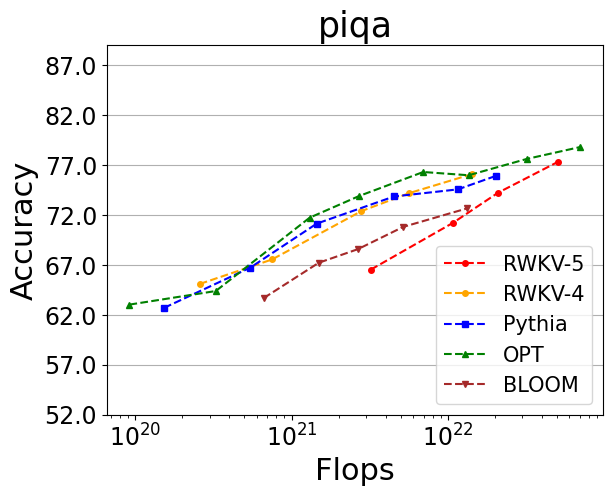

5: winogrande 
 0    3.209457e+21
1    1.081589e+22
2    2.093898e+22
3    5.073600e+22
Name: flops, dtype: float64 0    53.1
1    59.8
2    63.7
3    68.4
Name: winogrande, dtype: float64
4: winogrande 
 1       258638054400000000000
5       749705932800000000000
9      2794948485120000000000
13     5652913305600000000000
17    14226807767040000000000
Name: flops, dtype: object 1     50.83
5     51.14
9     54.62
13    59.59
17    61.01
Name: winogrande, dtype: object
winogrande


/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:224: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv5['flops'], rwkv5[task] * 1, "o-", markersize=4, color='red', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:230: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv['flops'], rwkv[task] * 1, "o-", markersize=4, color='orange', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:231: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pythia['flops'], pythia[task] * 1, "s-", ma

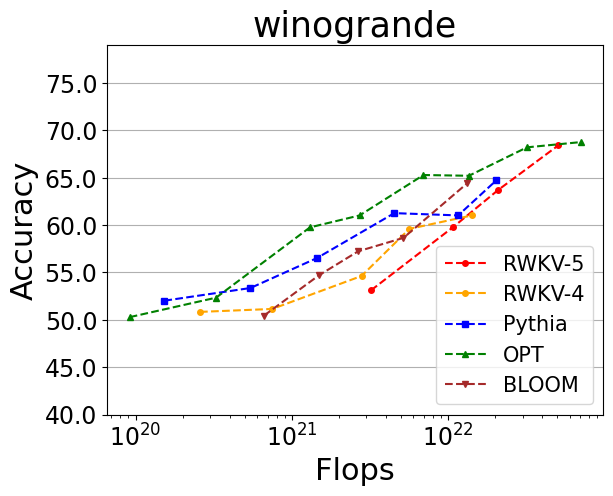

5: arc_challenge 
 0    3.209457e+21
1    1.081589e+22
2    2.093898e+22
3    5.073600e+22
Name: flops, dtype: float64 0    26.3
1    33.5
2    36.6
3    46.1
Name: arc_challenge, dtype: float64
4: arc_challenge 
 1       258638054400000000000
5       749705932800000000000
9      2794948485120000000000
13     5652913305600000000000
17    14226807767040000000000
Name: flops, dtype: object 1     24.15
5     25.17
9     29.44
13    33.11
17    37.46
Name: arc_challenge, dtype: object
arc_challenge


/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:224: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv5['flops'], rwkv5[task] * 1, "o-", markersize=4, color='red', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:230: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv['flops'], rwkv[task] * 1, "o-", markersize=4, color='orange', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:231: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pythia['flops'], pythia[task] * 1, "s-", ma

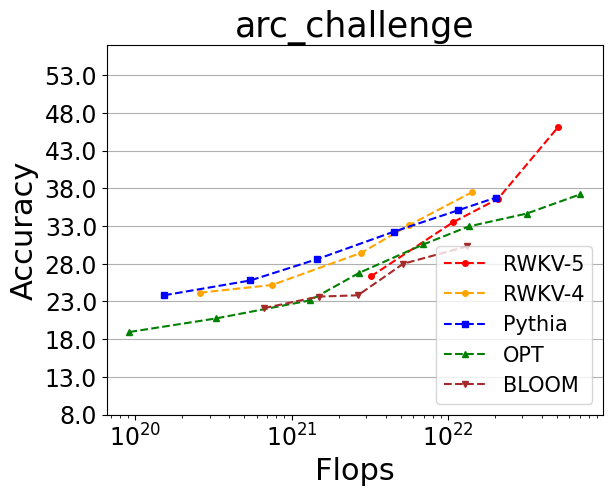

5: arc_easy 
 0    3.209457e+21
1    1.081589e+22
2    2.093898e+22
3    5.073600e+22
Name: flops, dtype: float64 0    54.0
1    64.3
2    71.1
3    74.9
Name: arc_easy, dtype: float64
4: arc_easy 
 1       258638054400000000000
5       749705932800000000000
9      2794948485120000000000
13     5652913305600000000000
17    14226807767040000000000
Name: flops, dtype: object 1     47.47
5     52.86
9     60.48
13    65.19
17     67.8
Name: arc_easy, dtype: object
arc_easy


/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:224: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv5['flops'], rwkv5[task] * 1, "o-", markersize=4, color='red', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:230: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv['flops'], rwkv[task] * 1, "o-", markersize=4, color='orange', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:231: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pythia['flops'], pythia[task] * 1, "s-", ma

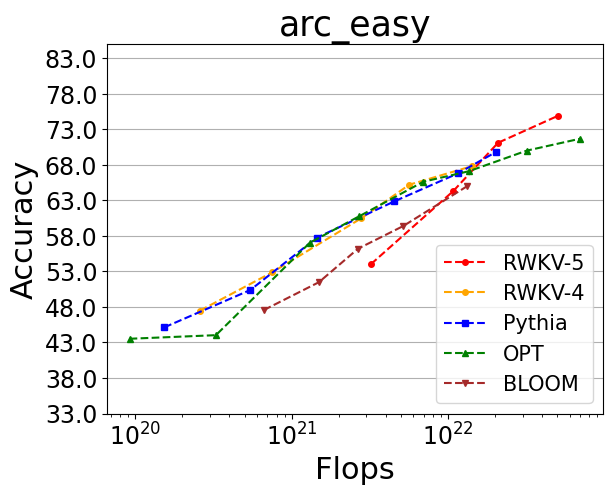

5: sciq 
 0    3.209457e+21
1    1.081589e+22
2    2.093898e+22
3    5.073600e+22
Name: flops, dtype: float64 0    86.6
1    89.7
2    92.5
3    95.1
Name: sciq, dtype: float64
4: sciq 
 1       258638054400000000000
5       749705932800000000000
9      2794948485120000000000
13     5652913305600000000000
17    14226807767040000000000
Name: flops, dtype: object 1     77.5
5     80.3
9     85.0
13    86.5
17    88.8
Name: sciq, dtype: object
sciq


/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:224: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv5['flops'], rwkv5[task] * 1, "o-", markersize=4, color='red', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:230: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rwkv['flops'], rwkv[task] * 1, "o-", markersize=4, color='orange', linestyle='--')
/var/folders/69/nwsxz_yj1153dt2_1nmj_mf40000gn/T/ipykernel_43625/3649456794.py:231: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pythia['flops'], pythia[task] * 1, "s-", ma

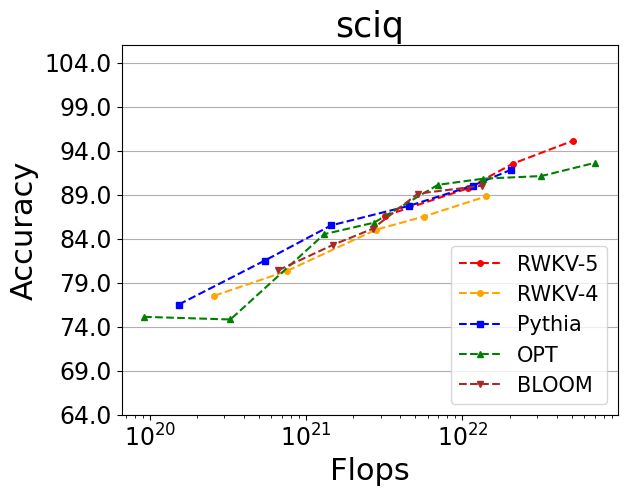

In [9]:
tasks =  ["lambada", "piqa", "winogrande", "arc_challenge", "arc_easy", "sciq"]


flops_d = {k:v for k,v in dd.items() if not k.startswith("v5")}

flops_d.update({
           # "rwkv5-0.195b":1.192568832*1e9, 
           "rwkv5-0.46b":2.865586176*1e9, 
           "rwkv5-1.68b":9.657040896*1e9,
            "rwkv5-3b":1.8695516160*1e10,
           "rwkv5-7.52b":4.53*1e10})


print(flops_d)

train_flops_d = {k.split("/")[-1]:v*name2num_trainedtokens(k) for k,v in flops_d.items()}


# opt_acc, opt_params = get_data("opt", tasks)
# bloom_acc, bloom_params = get_data("bloom", tasks)

opt_acc, opt_flops = get_flops_data("opt", tasks, train_flops_d)
bloom_acc, bloom_flops = get_flops_data("bloom", tasks, train_flops_d)
# pythia_acc, pythia_flops = get_flops_data("pythia", tasks, train_flops_d)
print(bloom_flops)
print(opt_flops)
rwkv4, pythia = preprocess_rwkv4()
rwkv5  = preprocess_rwkv5()
print(rwkv5)


rwkv4["flops"] = [v*330*(10 ** 9) for v in get_flops_rwkv4(compute_bp_factor=2)]
pythia["flops"] = sorted([v for k, v in train_flops_d.items() if "pythia" in k])

rwkv5["flops"] = [flops_d[name]*name2num_trainedtokens(name) for name in [
           # "rwkv5-0.195b", 
           "rwkv5-0.46b", 
           "rwkv5-1.68b",
           "rwkv5-3b",                                                              
           "rwkv5-7.52b" ]
                 ]

# assert False, opt_flops
# assert False, rwkv5["flops"]
#assert False, rwkv5
# rwkv['params'] = rwkv['params'].apply(lambda x: float(x.split(",")[0]))
# pythia['params'] = pythia['params'].apply(lambda x: float(x))

print(opt_acc)
print(opt_flops)
#print(rwkv4["flops"])

#assert False, rwkv5

plot(rwkv4, rwkv5, pythia, opt_flops, opt_acc, bloom_flops, bloom_acc, tasks)



In [61]:
!ls

RWKV.csv              acc_arc_easy.png      acc_winogrande.png
RWKV_5_and_6.100.csv  acc_lambada.png       accuracy.ipynb
RWKV_5_and_6.csv      acc_piqa.png          pythia
acc_arc_challenge.png acc_sciq.png          rwkv5plot


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
!ls pythia/evals/

README.md  bloom      names.txt  pythia-v0
bias-evals csv        opt        pythia-v1


In [97]:
[v for v in get_flops_rwkv4(compute_bp_factor=1.0)]

[1567503360.0, 4543672320.0, 16939081728.0, 34260080640.0, 86223077376.0]

In [176]:
D = 576
L = 12
V = 65536

D = 2560
L = 32
V = 65536

D = 2048
L = 24
V = 65536

# 13*(D**2)*L + 14*D*L + 4*D + 2*D*V 
78*(D**2)*L + 3960*D*L + 24*D + 12*D*V 

9657040896

In [118]:
768/12

64.0

In [121]:
12*48

576

In [154]:
!pwd


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/a-saito/Downloads/rwkv5paper/calc_flops


In [170]:
78*(D**2)*L + 3960*D*L + 24*D + 12*D*V

790912512

In [178]:
9657040896/1e9


9.657040896

In [179]:
D = 1024
L = 24
V = 65536

# 13*(D**2)*L + 14*D*L + 4*D + 2*D*V 
78*(D**2)*L + 3960*D*L + 24*D + 12*D*V 

2865586176

In [180]:
2865586176/1e9

2.865586176

In [181]:
D = 768
L = 12
V = 65536

# 13*(D**2)*L + 14*D*L + 4*D + 2*D*V 
78*(D**2)*L + 3960*D*L + 24*D + 12*D*V 

1192568832

In [182]:
1192568832/1e9

1.192568832